# Data Science Project: Credit Card Fraud Detection

Credit card fraud is the most common type of identity theft. With an estimated 1.5 billion credit cards in the U.S. alone, it’s no surprise that millions of people fall as victims every year ([Brex](https://www.brex.com/learn/fraud-security/what-is-credit-card-fraud/)).

It is not a challenging problem only for credit cardholders, but also for banks, government, insurance companies, the public sector, sales, and healthcare. 

In this scenario, machine learning plays an essential role in fraud detection. It uses supervised methods (logistic regression, decision trees, random forest, time-series analysis, etc.) and unsupervised methods (cluster analysis, principal component analysis, etc.) to accurately predict when a fraud transaction occurs in the system so that customers are not charged for items that they did not purchase.  

This project is intended to analyse a [data set](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) that contains transactions made by credit cards in September 2013 by European cardholders.



# Import libraries and read the data set

In [1]:
import pandas as pd
import numpy as np 
from numpy import where

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML 

credit_card = pd.read_csv("creditcard.csv")
print(credit_card.head(5))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Exploratory Data Analysis

In [2]:
print(credit_card.info())
print(len(credit_card))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

As we can see above, the data set contains 284807 rows and 31 columns.The column V1 until V28 are the principal components obtained from a PCA transformation to preserve confidentiality. The column "Amount" represents the transaction amount. Finally, the column "Class" shows whether the transaction was a fraud (1) or not (0). 

In [3]:
# Calculating the number of frauds and non-frauds in our data set

fraud_count = credit_card['Class'].value_counts()
print(fraud_count)

0    284315
1       492
Name: Class, dtype: int64


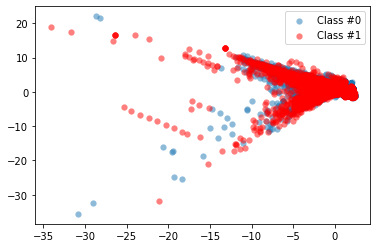

In [4]:
# plotting the fraud and non-fraud data points

def prep_data(df):
    X = df.iloc[:, 1:28]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y = np.array(y).astype(int)
    return X, y

def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Class #0', alpha=0.5, linewidth=0.15)
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Class #1', alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

X, y = prep_data(credit_card)

plot_data(X, y)

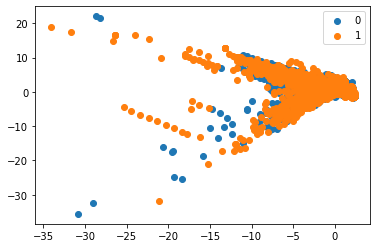

In [5]:
# plotting with a different method
# scatter plot of examples by class label
for label, _ in fraud_count.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

As the amount of fraudulent transactions is much less than the non-fraudulent ones. For this imbalanced classification, I'll be using SMOTE, short name for Synthetic Minority Oversampling Technique ([Reference](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)) for the minority class. 

In [20]:
from sklearn.model_selection import train_test_split

X = credit_card.drop(['Class'], axis=1)
y = credit_card.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)
#oversampling the train data set using SMOTE
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)

Before Counter({0: 170578, 1: 306})
After Counter({0: 170578, 1: 170578})


The SMOTE method has balanced our data, and now the minority class is equaly large as the majority class.

# Implementing Logistic Regression

In [22]:
from imblearn.pipeline import Pipeline

# Defining which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
lr = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', lr)])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(pd.crosstab(y_test, predictions, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud       0     1
Actual Fraud               
0              111888  1849
1                  25   161


# Conclusion

In conclusion, our Logistic Regression model was able to capture 161 out of 186 fraudulent cases, giving us 86.56% of accuracy. One challenge that fraud detection models are facing is that frauds are constantly changing so that they can go unnoticed on the system.